# Object Detection Batch Inference with PyTorch

This example demostrates how to do object detection batch inference at scale with a pre-tained PyTorch model and Ray Data.

Here is what you'll do:
1. Perform object detection on a single image with a pre-trained PyTorch model.
1. Scale the PyTorch model with Ray Data, and perform object detection batch inference on a large set of images.
1. Verify the inference results and save them to an external storage.
1. Learn how to use Ray Data with GPUs.


## Before You Begin

Install the following dependencies if you haven't already.

In [1]:
!pip install ray[data] torchvision

## Object Detection on a single Image with PyTorch

First, let's take a look at this [object detection example](https://pytorch.org/vision/stable/models.html#object-detection) from PyTorch's official documentation. 

This example includes the following steps:
1. Download an image file from the Internet.
2. Load and intialize a pre-trained PyTorch model.
3. Apply inference preprocessing transforms.
4. Use the model for inference.
5. Visualize the result.

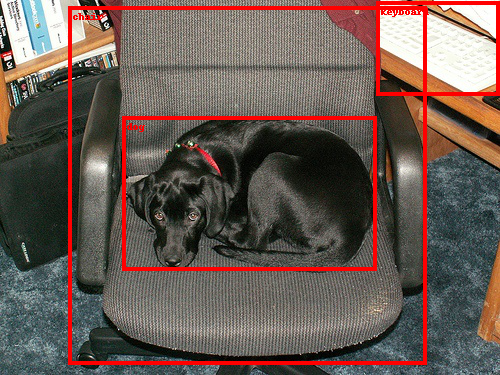

In [ ]:
import requests
from PIL import Image
from torchvision import transforms
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# 1: Download an image file from the Internet.
url = "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg"
img = Image.open(requests.get(url, stream=True).raw)

# 2: Load and intialize the model.
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# 3: Apply inference preprocessing transforms.
img = transforms.Compose([transforms.PILToTensor()])(img)
preprocess = weights.transforms()
batch = [preprocess(img)]

# 4: Use the model for interence.
prediction = model(batch)[0]

# 5: Visualize the result.
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, 
                          boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4)
im = to_pil_image(box.detach())
display(im)

## Scaling with Ray Data

Then we will scale the previous example to a large set of images. We will use Ray Data to do batch inference in a distributed fashion.

### Loading the Image Dataset

First, we use the {meth}`ray.data.read_images <ray.data.read_images>` API to load a prepared image dataset from S3. We can use the {meth}`schema <ray.data.Dataset.schema>` API to check the schema of the dataset. As we can see, it has one column named "image", and the value is the image data represented in `np.ndarray` format.

In [3]:
import ray

ds = ray.data.read_images("s3://anonymous@air-example-data/AnimalDetection/JPEGImages")
display(ds.schema())

2023-05-12 10:02:25,661	INFO worker.py:1607 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-05-12 10:02:30,877	WARNING dataset.py:255 -- Important: Ray Data requires schemas for all datasets in Ray 2.5. This means that standalone Python objects are no longer supported. In addition, the default batch format is fixed to NumPy. To revert to legacy behavior temporarily, set the environment variable RAY_DATA_STRICT_MODE=0 on all cluster processes.

Learn more here: https://docs.ray.io/en/master/data/faq.html#migrating-to-strict-mode


Schema({'image': numpy.ndarray(ndim=3, dtype=uint8)})

### Batch inference with Ray Data

Then let's use Ray Data to scale the PyTorch example and do batch inference in a distributed fashion.

As we can see from the PyTorch example, model inference consists of 2 steps: preprocessing the image and model inference. 

First let's convert the preprocessing code to Ray Data. We'll package the preprocessing code within a `preprocess_image` function. This function should take only one argument, which is a dict that contains a single data item in the dataset.

In [4]:
import numpy as np
import torch
from ray.data.extensions.tensor_extension import create_ragged_ndarray
from torchvision import transforms
from torchvision.models.detection import (FasterRCNN_ResNet50_FPN_V2_Weights,
                                          fasterrcnn_resnet50_fpn_v2)
from typing import Dict


def preprocess_image(data: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    preprocessor = transforms.Compose(
        [transforms.ToTensor(), weights.transforms()]
    )
    return {
        "image": data["image"],
        "transformed": preprocessor(data["image"]),
    }

Then we use the {meth}`map <ds.data.Dataset.map>` API to apply the function to the whole dataset.

In [5]:
ds = ds.map(preprocess_image)

2023-05-12 10:02:32,510	WARNING dataset.py:4352 -- The `map`, `flat_map`, and `filter` operations are unvectorized and can be very slow. If you're using a vectorized transformation, consider using `.map_batches()` instead.


Next, let's convert the model inference part. Compared with preprocessing, model inference has 2 differences:
1. Model loading and initialization is usually expensive. 
1. Model inference can be optimized with hardware acceleration if we process data in batches.

Thus, we convert the model inference code to the following `ObjectDetectionModel` class. In this class, we put the expensive model loading and initialization code in the `__init__` constructor, which will run only once. And we put the model inference code in the `__call__` method, which will be called for each batch.

The `__call__` method takes a batch of data items, instead of a single one. In this case, the batch is also a dict that has one key named "image", and the value is an array of images represented in `np.ndarray` format. We can also use the {meth}`take_batch <ray.data.Dataset.take_batch>` API to fetch a single batch, and inspect its internal data structure.

In [6]:
single_batch = ds.take_batch(batch_size=3)
display(single_batch)

class ObjectDetectionModel:
    def __init__(self):
        # Define the model loading and initialization code in `__init__`.
        self.weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        self.model = fasterrcnn_resnet50_fpn_v2(
            weights=self.weights,
            box_score_thresh=0.9,
        )
        self.model.eval()

    def __call__(self, input_batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        # Define the per-batch inference code in `__call__`.
#         batch = [torch.from_numpy(image) for image in input_batch["transformed"]]
        batch = [image for image in input_batch["transformed"]]
        predictions = self.model(batch)
        return {
            "image": input_batch["image"],
            "labels": create_ragged_ndarray([pred["labels"].detach().numpy() for pred in predictions]),
            "boxes": create_ragged_ndarray([pred["boxes"].detach().numpy() for pred in predictions]),
        }

2023-05-12 10:02:32,582	INFO streaming_executor.py:91 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map]
2023-05-12 10:02:32,582	INFO streaming_executor.py:92 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-05-12 10:02:32,583	INFO streaming_executor.py:94 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-05-12 10:02:35,158	INFO streaming_executor.py:149 -- Shutting down <StreamingExecutor(Thread-10, started daemon 16243781632)>.


{'image': array([array([[[173, 153, 142],
                [255, 246, 242],
                [255, 245, 245],
                ...,
                [255, 255, 244],
                [237, 235, 223],
                [214, 212, 200]],
 
               [[124, 105,  90],
                [255, 249, 238],
                [251, 244, 236],
                ...,
                [255, 252, 245],
                [255, 254, 247],
                [247, 244, 237]],
 
               [[ 56,  37,  20],
                [255, 253, 239],
                [248, 248, 236],
                ...,
                [248, 247, 243],
                [248, 247, 243],
                [254, 253, 249]],
 
               ...,
 
               [[ 64,  78,  87],
                [ 63,  74,  80],
                [105, 113, 115],
                ...,
                [ 94, 105, 109],
                [ 90,  99, 104],
                [ 84,  91,  97]],
 
               [[ 68,  86,  96],
                [ 69,  82,  88],
               

Then we use the {meth}`map_batches <ray.data.Dataset.map_batches>` API to apply the model to the whole dataset. 

The first parameter of `map` and `map_batches` is the user-defined function (UDF), which can either be a function or a class. Function-based UDFs will run as short-running [Ray tasks](https://docs.ray.io/en/latest/ray-core/key-concepts.html#tasks), and class-based UDFs will run as long-running [Ray actors](https://docs.ray.io/en/latest/ray-core/key-concepts.html#actors). For class-based UDFs, we use the `compute` argument to specify the number of parallel actors. And the `batch_size` argument indicates the number of images in each batch.

In [7]:
ds = ds.map_batches(
    ObjectDetectionModel,
    compute=ray.data.ActorPoolStrategy(size=4),
    batch_size=4,
)

### Verify and Save Results

Then let's take a small batch and verify the inference results with visualization.

2023-05-12 10:02:35,468	INFO streaming_executor.py:91 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[ReadImage->Map->MapBatches(ObjectDetectionModel)]
2023-05-12 10:02:35,469	INFO streaming_executor.py:92 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-05-12 10:02:35,469	INFO streaming_executor.py:94 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-05-12 10:02:35,481	INFO actor_pool_map_operator.py:114 -- ReadImage->Map->MapBatches(ObjectDetectionModel): Waiting for 4 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-05-12 10:03:44,660	INFO streaming_executor.py:149 -- Shutting down <StreamingExecutor(Thread-26, started daemon 16243781632)>.
2023-05-12 10:03:44,754	WARNING actor_pool_map_operator.py:264 -- To ensure full parallelization across an actor pool of size 4, the specified batch size should be at most 3. Your configured batch size for this operator was 4.


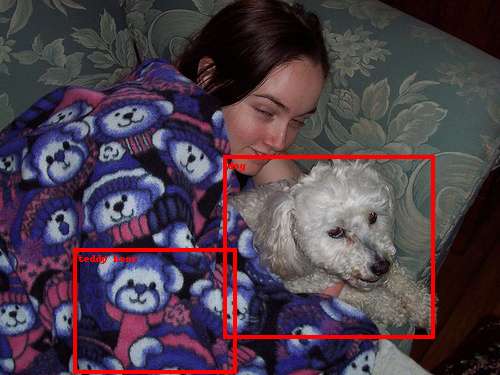

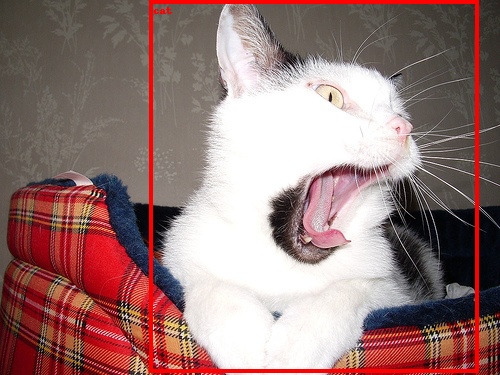

In [8]:
from torchvision.transforms.functional import convert_image_dtype, to_tensor

batch = ds.take_batch(batch_size=2)
for image, labels, boxes in zip(batch["image"], batch["labels"], batch["boxes"]):
    image = convert_image_dtype(to_tensor(image), torch.uint8)
    labels = [weights.meta["categories"][i] for i in labels]
    boxes = torch.from_numpy(boxes)
    img = to_pil_image(draw_bounding_boxes(
        image,
        boxes,
        labels=labels,
        colors="red",
        width=4,
    ))
    display(img)

If the samples look good, we can proceed with saving the results to an external storage, e.g., S3 or local disks. See [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html) for all supported stoarges and file formats.

```python
ds.write_parquet("local://tmp/inference_results")
```

### Using GPUs

Ray Data can also work on GPU workers. To make the previous example work with GPUs, we only need to make some small changes.

```diff
          self.model = fasterrcnn_resnet50_fpn_v2(
             weights=self.weights,
             box_score_thresh=0.9,
-        )
+        ).cuda()
         self.model.eval()

     def __call__(self, input_batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
         # Define the per-batch inference code in `__call__`.
-        batch = [torch.from_numpy(image) for image in input_batch["transformed"]]
+        batch = [torch.from_numpy(image).cuda() for image in input_batch["transformed"]]
         predictions = self.model(batch)
         return {
             "image": input_batch["image"],
-            "labels": create_ragged_ndarray([pred["labels"].detach().numpy() for pred in predictions]),
-            "boxes": create_ragged_ndarray([pred["boxes"].detach().numpy() for pred in predictions]),
+            "labels": create_ragged_ndarray([pred["labels"].detach().cpu().numpy() for pred in predictions]),
+            "boxes": create_ragged_ndarray([pred["boxes"].detach().cpu().numpy() for pred in predictions]),
         }

```

```diff
 ).map_batches(
     ObjectDetectionModel,
     compute=ray.data.ActorPoolStrategy(size=4),
     batch_size=4,
+    num_gpus=1,
 )

```

The `num_gpus` argument specifies the number of GPUs needed for each `ObjectDetectionModel` instance. Ray scheduler can handle heterogeous resource requirements, in order to maximize the resource utilization. In this case, the `ObjectDetectionModel` instances will run on GPU nodes and `preprocess_image` instances will run CPU nodes.